# Infant Mortality Indicator
- **Project: Analysis of the dynamics of COVID-19 infection in Colombia**
- **Analysis: Clustering**
- **Data: SIVIGILA - Weekly infant mortality ratio by Department in Colombia [2017, 2018 & 2020]**
- **Created by: Andrés Segura Tinoco**
- **Created on: July 23, 2020**

In [1]:
# Load Pandas libraries
import warnings
import pandas as pd
import numpy as np
import math
from collections import Counter

In [2]:
# Load scikit-learn library for K-Means
warnings.simplefilter("ignore")
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Import Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook

``` python
conda install -c conda-forge tslearn
```

## 0. Load data

In [4]:
# Read raw data
csv_file = 'im_weekly_dpt_pivot_2017_2019_dtw.csv'
data_url = '../data/' + csv_file
rawdata = pd.read_csv(data_url, index_col=['Date'])
print(rawdata)

           AMAZONAS  ANTIOQUIA  ARAUCA  ATLANTICO  BOGOTA  BOLIVAR  BOYACA  \
Date                                                                         
1/1/2017          0         22       0         13      20       16       3   
1/8/2017          1         25       3          5      34       11       5   
1/15/2017         0         21       4         10      29        8       3   
1/22/2017         1         28       0         14      32       10       4   
1/29/2017         2         22       2          9      26       11       9   
...             ...        ...     ...        ...     ...      ...     ...   
1/19/2020         1         18       0          8      26        5       6   
1/26/2020         0         16       2          5      23        4       2   
2/2/2020          1         15       2          6      29        2       4   
2/9/2020          0         18       1          8      23        4       1   
2/16/2020         0         17       1          4      18       

#### Result
Data for:
- 32 Departments
- 1 DC

In [5]:
# Read departments data
dataURL = '../data/col_dpt_list.csv'
dpt_data = pd.read_csv(dataURL)

# Save zone by departments
dpt_zone = {}
for ix, row in dpt_data.iterrows():
    dpt = row['department']
    zone = row['zone']
    dpt_zone[dpt] = zone

dpt_zone

{'AMAZONAS': 'AMAZONIA',
 'CAQUETA': 'AMAZONIA',
 'GUAINIA': 'AMAZONIA',
 'GUAVIARE': 'AMAZONIA',
 'PUTUMAYO': 'AMAZONIA',
 'VAUPES': 'AMAZONIA',
 'ANTIOQUIA': 'ANDINA',
 'BOGOTA': 'ANDINA',
 'BOYACA': 'ANDINA',
 'CALDAS': 'ANDINA',
 'CUNDINAMARCA': 'ANDINA',
 'HUILA': 'ANDINA',
 'NORTE SANTANDER': 'ANDINA',
 'QUINDIO': 'ANDINA',
 'RISARALDA': 'ANDINA',
 'SANTANDER': 'ANDINA',
 'TOLIMA': 'ANDINA',
 'ATLANTICO': 'CARIBE',
 'BOLIVAR': 'CARIBE',
 'CESAR': 'CARIBE',
 'CORDOBA': 'CARIBE',
 'LA GUAJIRA': 'CARIBE',
 'MAGDALENA': 'CARIBE',
 'SAN ANDRES': 'CARIBE',
 'SUCRE': 'CARIBE',
 'ARAUCA': 'ORINOQUIA',
 'CASANARE': 'ORINOQUIA',
 'META': 'ORINOQUIA',
 'VICHADA': 'ORINOQUIA',
 'CAUCA': 'PACIFICO',
 'CHOCO': 'PACIFICO',
 'NARIÑO': 'PACIFICO',
 'VALLE DEL CAUCA': 'PACIFICO'}

## 1. Data Quality process with Standardization

In [6]:
# Split data
date_list = pd.DataFrame(rawdata.index)
data = rawdata.reset_index(drop=True)
col_list = {}
for col in data.columns:
    col_list[col] = data[col].max()

In [7]:
# Standardize data
std = False
if std:
    for col, max_value in col_list.items():
        if max_value > 0:
            data[col] = data[col] / max_value
    print(data)

In [8]:
# Transform data
x = []
for dpt in list(col_list.keys()):
    ts = []
    for v in data[dpt].values:
        ts.append([v])
    x.append(ts)
x = np.array(x)

## 2. Correlation matrix between Departments

In [9]:
# Calculate department correlations
corr = pd.DataFrame(data=data.values, columns=list(col_list.keys())).corr()

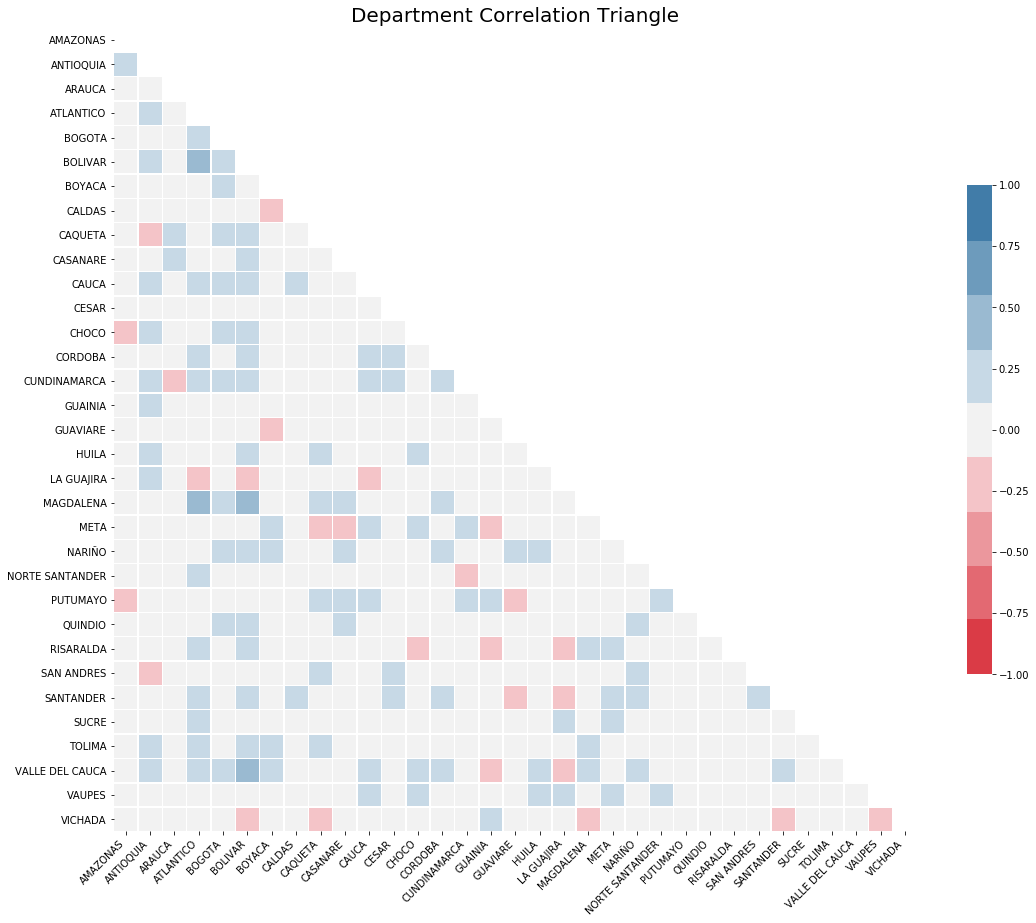

In [10]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 240, n = 9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment = 'right');

# Add title
ax1.set_title("Department Correlation Triangle", fontsize = 20)
plt.show()

## 3. Clustering: K-Means

- Algorithm: distance time warping (DTW)

### 3.1. Calculating the Euclidean Jambu elbow

In [11]:
# Creating training dataset
n_cluster = 5
ds_train = x
Nc = range(1, 20)

In [12]:
# Calculating the Jambu Elbow scores
kmeans = [TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=5, random_state=0) for i in Nc]
score = [kmeans[i].fit(ds_train).inertia_ for i in range(len(kmeans))]

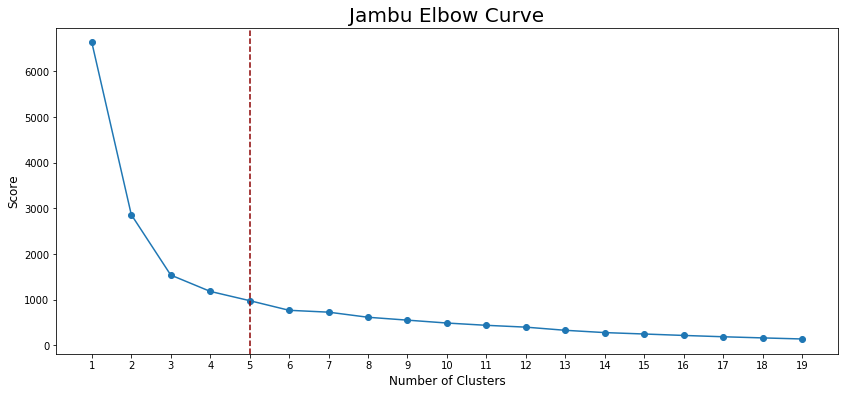

In [13]:
# Plot the results
fig, ax0 = plt.subplots(figsize=(14, 6))
plt.plot(Nc, score, marker='o')
plt.axvline(x=n_cluster, color="#8b0000", linestyle="--")
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.title("Jambu Elbow Curve", fontsize = 20)
plt.show()

### 3.2. Calculating the DTW Jambu elbow

In [14]:
# Calculating the Jambu Elbow scores
kmeans = [TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=5, max_iter_barycenter=5, random_state=0) for i in Nc]
score = [kmeans[i].fit(ds_train).inertia_ for i in range(len(kmeans))]

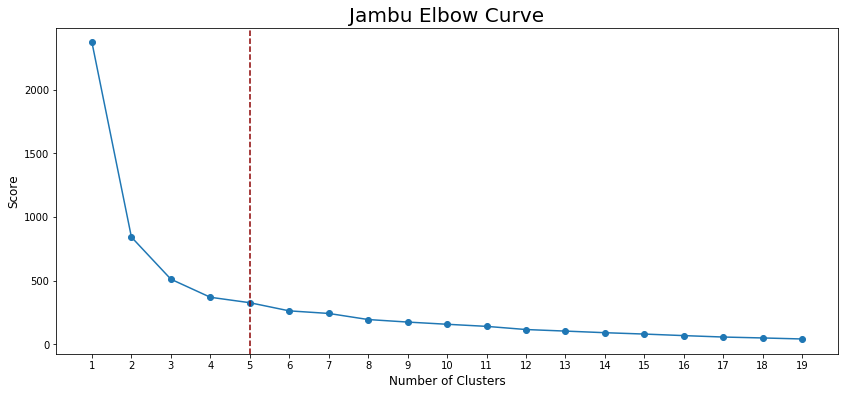

In [15]:
# Plot the results
fig, ax0 = plt.subplots(figsize=(14, 6))
plt.plot(Nc, score, marker='o')
plt.axvline(x=n_cluster, color="#8b0000", linestyle="--")
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.title("Jambu Elbow Curve", fontsize = 20)
plt.show()

### 3.3. Clustering the data

In [16]:
# Calculates the K-Means for (x, y) dataset
def run_kmeans(k_clusters):
    #kmeans = TimeSeriesKMeans(n_clusters=k_clusters, metric="euclidean", max_iter=5, random_state=0)
    kmeans = TimeSeriesKMeans(n_clusters=k_clusters, metric="dtw", max_iter=5, max_iter_barycenter=5, random_state=0)
    kmeans = kmeans.fit(ds_train)
    
    # Getting the cluster labels
    clusters = kmeans.predict(ds_train)
    
    # Centroid values
    centroids = kmeans.cluster_centers_
    
    return clusters, centroids

In [17]:
# Create interactive control to control k value
clusters, centroids = run_kmeans(k_clusters=n_cluster)

In [18]:
clusters

array([0, 1, 0, 3, 1, 2, 4, 0, 0, 0, 4, 2, 4, 2, 2, 0, 0, 4, 2, 2, 4, 2,
       4, 0, 0, 0, 0, 4, 4, 4, 3, 0, 0], dtype=int64)

## 4. Clusters Description

In [19]:
# CLustering results dataframe
df_result = pd.DataFrame(columns=["n_item", "std_dev", "n_item_2", "w_std_dev"])

In [20]:
# Set color list
color_list = ["#1f77b4", "#ff7f0e", "#d62728", "#2ca02c", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

### 4.1. Cluster sizes

In [21]:
cluster_count = Counter()
for ix in clusters:
    c_name = str(ix + 1)
    cluster_count[c_name] += 1

# Cooking dataframe
df = pd.DataFrame.from_records(cluster_count.most_common(), columns = ['cluster', 'frequency']).sort_values(by=['cluster'])

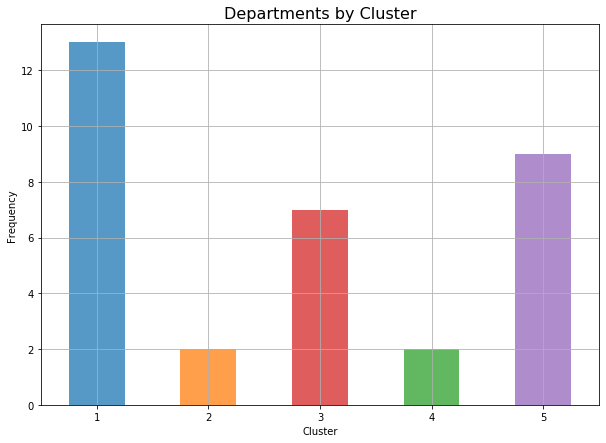

In [22]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax, x='cluster', y='frequency', alpha=0.75, figsize=(10, 7), color=color_list)
plt.title('Departments by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
ax.get_legend().remove()
ax.grid()
plt.xticks(rotation=0)
plt.show()

### 4.2. Regions by cluster

In [23]:
cluster_data = Counter()
ix = 0
for k, v in dpt_zone.items():
    cluster = str(clusters[ix] + 1)
    zone = v
    if not cluster in cluster_data:
        cluster_data[cluster] = Counter()
    cluster_data[cluster][zone] += 1
    ix += 1

sorted(cluster_data.items())

[('1',
  Counter({'AMAZONIA': 2,
           'ANDINA': 5,
           'CARIBE': 2,
           'ORINOQUIA': 2,
           'PACIFICO': 2})),
 ('2', Counter({'AMAZONIA': 2})),
 ('3', Counter({'AMAZONIA': 1, 'ANDINA': 3, 'CARIBE': 3})),
 ('4', Counter({'AMAZONIA': 1, 'PACIFICO': 1})),
 ('5', Counter({'ANDINA': 3, 'CARIBE': 3, 'ORINOQUIA': 2, 'PACIFICO': 1}))]

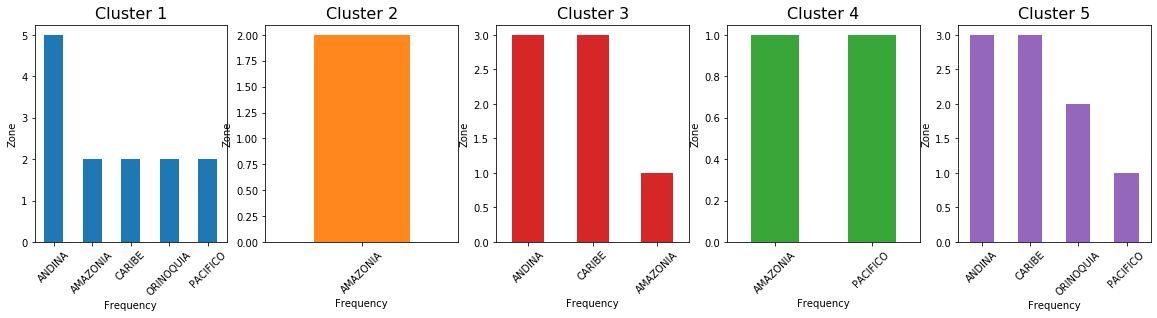

In [24]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
fig = plt.figure(figsize = (20, 4))
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

for ix in clusters:
    ax = plt.subplot(1, n_cluster, ix + 1)
    c_name = str(ix + 1)
    data = cluster_data[str(c_name)].most_common()
    df = pd.DataFrame.from_records(data, columns = ['zone', 'frequency']).sort_values(by='frequency', ascending=False)
    df.plot.bar(ax=ax, x='zone', y='frequency', color=color_list[ix], alpha=0.75)
    ax.get_legend().remove()
    plt.title('Cluster ' + c_name, fontsize=16)
    plt.xlabel('Frequency')
    plt.ylabel('Zone')
    plt.xticks(rotation=45)

plt.show()

### 4.3. Departments by cluster

In [25]:
dpt_cluster = {}
for i in range(n_cluster):
    cluster_name = (i+1)
    dpt_list = []
    print('>> Cluster %s:' % cluster_name)
    
    for j in range(len(clusters)):
        if i == clusters[j]:
            dpt_list.append(list(col_list.keys())[j])
    
    dpt_cluster[cluster_name] = dpt_list
    print('  ', dpt_list)

>> Cluster 1:
   ['AMAZONAS', 'ARAUCA', 'CALDAS', 'CAQUETA', 'CASANARE', 'GUAINIA', 'GUAVIARE', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'VAUPES', 'VICHADA']
>> Cluster 2:
   ['ANTIOQUIA', 'BOGOTA']
>> Cluster 3:
   ['BOLIVAR', 'CESAR', 'CORDOBA', 'CUNDINAMARCA', 'LA GUAJIRA', 'MAGDALENA', 'NARIÑO']
>> Cluster 4:
   ['ATLANTICO', 'VALLE DEL CAUCA']
>> Cluster 5:
   ['BOYACA', 'CAUCA', 'CHOCO', 'HUILA', 'META', 'NORTE SANTANDER', 'SANTANDER', 'SUCRE', 'TOLIMA']


### 4.4. Show data by Departments by Cluster

In [26]:
# Read raw data
data_url = "../data/im_weekly_dpt_data.csv"
dptdata = pd.read_csv(data_url, parse_dates=["date"])
dptdata = dptdata.drop(dptdata[(dptdata.department == 'EXTERIOR')].index)
dptdata

department       date  value
0            AMAZONAS 2017-01-01      0
1           ANTIOQUIA 2017-01-01     22
2              ARAUCA 2017-01-01      0
3           ATLANTICO 2017-01-01     13
4              BOGOTA 2017-01-01     20
...               ...        ...    ...
5391        SANTANDER 2020-02-16      3
5392            SUCRE 2020-02-16      1
5393           TOLIMA 2020-02-16      2
5394  VALLE DEL CAUCA 2020-02-16      2
5395          VICHADA 2020-02-16      2

[5396 rows x 3 columns]

In [27]:
# Standardize data
if std:
    dptdata['value'] = dptdata['value'].astype(float)
    
    for ix, row in dptdata.iterrows():
        max_value = col_list[row['department']]
        if max_value > 0:
            new_value = row['value'] / max_value
            dptdata.at[ix,'value'] = new_value

In [28]:
dpt_ts = {}
for cluster, departments in dpt_cluster.items():
    for dpt in departments:
        df = dptdata[dptdata['department'] == dpt]
        ts = df.set_index('date')['value'].asfreq(freq='W')
        dpt_ts[dpt] = ts

In [29]:
# Average a list of time series
def avg_time_series(ts_data, ts_list, allow_dbl, c_name):
    avg_ts = None
    df = None
    n = len(ts_list)
    
    for dpt in ts_list:
        ts = ts_data[dpt]
        
        if avg_ts is None:
            avg_ts = ts
            df = pd.DataFrame(ts)
        else:
            avg_ts = avg_ts.add(ts, fill_value=0)
            df = pd.concat([df, pd.DataFrame(ts)], axis=1, sort=False)
    avg_ts = avg_ts / n
    
    if not allow_dbl:
        avg_ts = math.ceil(avg_ts)
    
    std_dev = 0
    max_value = 0
    if len(df.columns) > 1:
        for ix, row in df.iterrows():
            values = np.nan_to_num(row.values)
            max_value = max(np.max(values), max_value)
            std_dev += np.std(values)
        std_dev = 100.0 * std_dev / len(df) / max_value
    
    print('n time series:', n, ', std dev:', std_dev, 'max value:', max_value)
    df_result.loc[c_name - 1] = [n, std_dev, n * n, n * std_dev]
    
    return avg_ts

In [30]:
# Plot trends by year
def plot_cluster_curves(data, dpt_list, c_name, allow_dbl=True):
    plt.figure(figsize=(18, 5), dpi=200)
    
    # Plot all curves
    for dpt in dpt_list:
        ts = data[dpt]
        plt.plot(ts, label=dpt, alpha=0.25)
    
    # Plot average curve
    avg_ts = avg_time_series(data, dpt_list, allow_dbl, c_name)
    plt.plot(avg_ts, label='average', alpha=1, color='black')
        
    plt.title('Cluster %s IM trends' % c_name, fontsize=16)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Num. Deaths', fontsize=10)
    plt.xticks(fontsize=10)
    plt.legend()
    plt.show()

n time series: 13 , std dev: 15.350275518677691 max value: 8.0


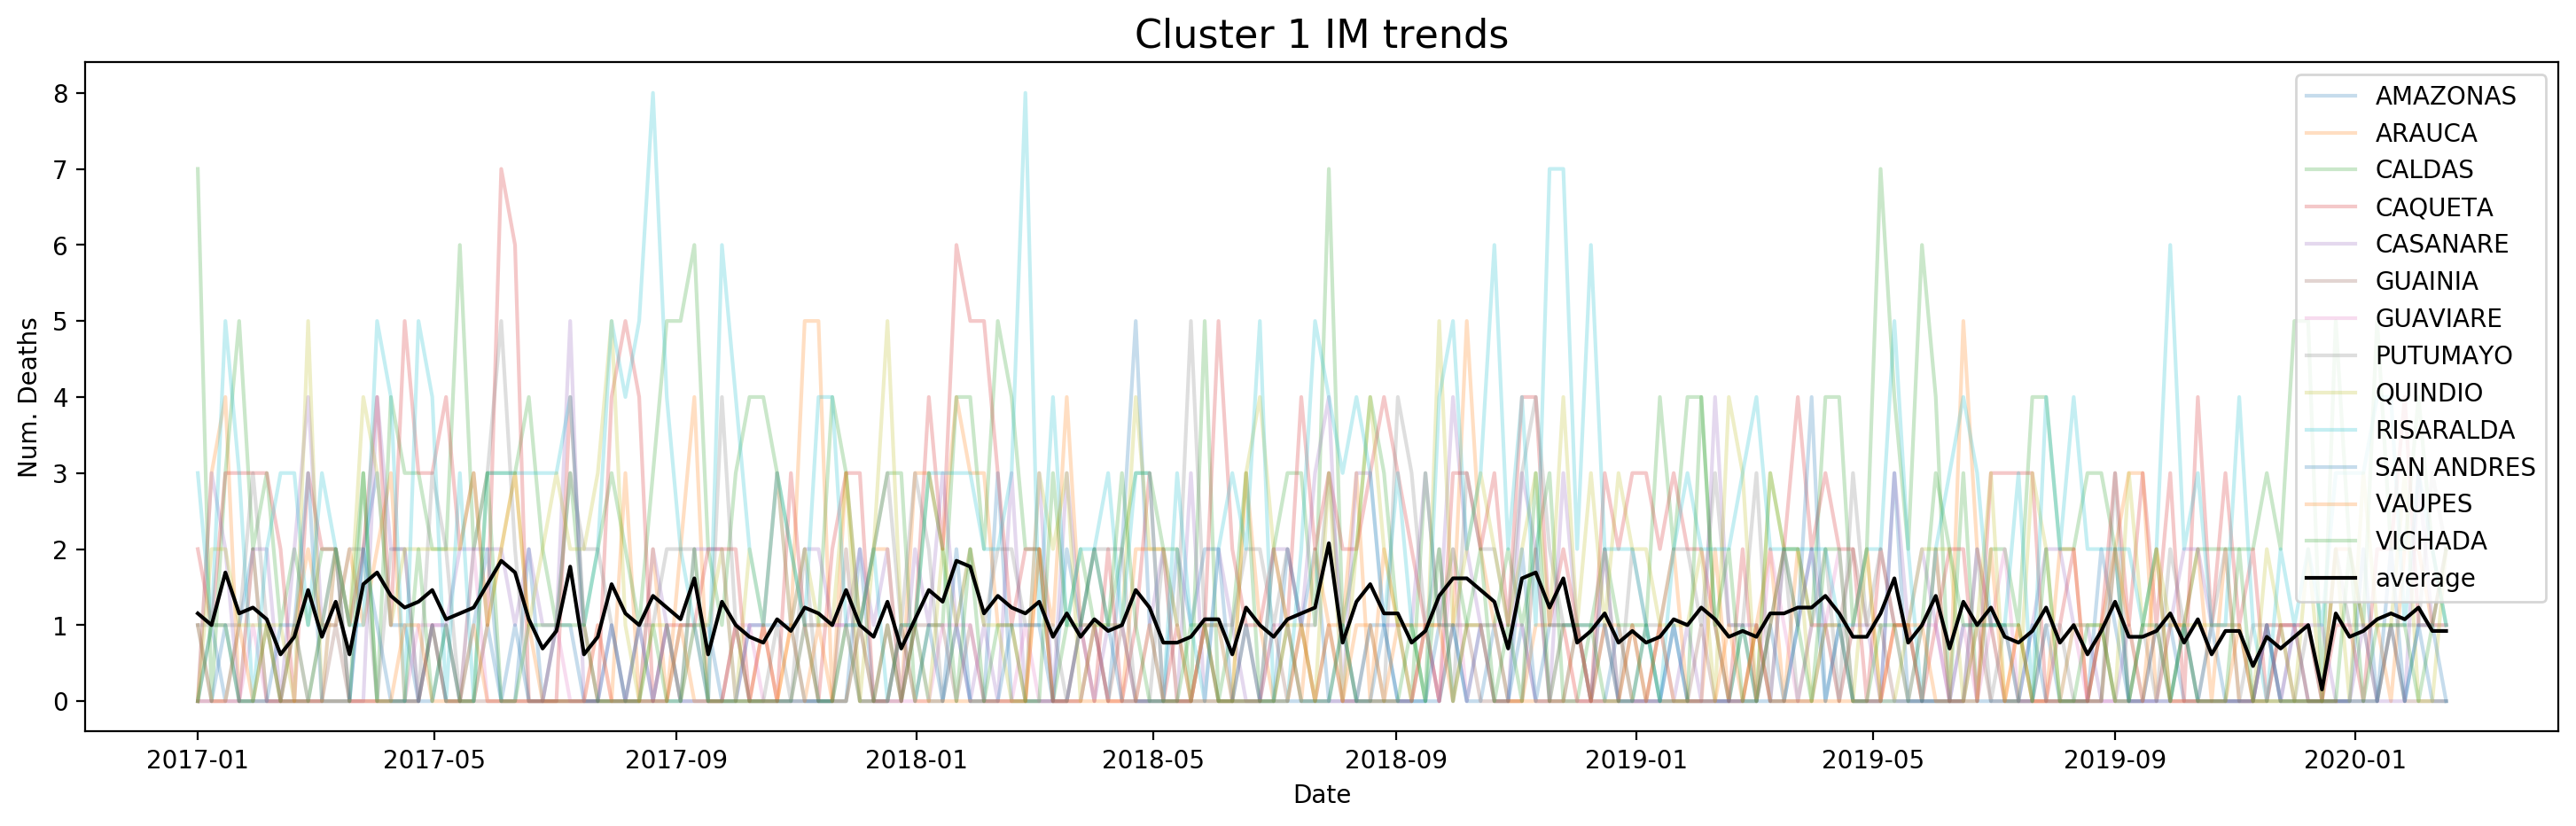

In [31]:
# Plot cluster 1
c_name = 1
plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

n time series: 2 , std dev: 7.940084835630965 max value: 46


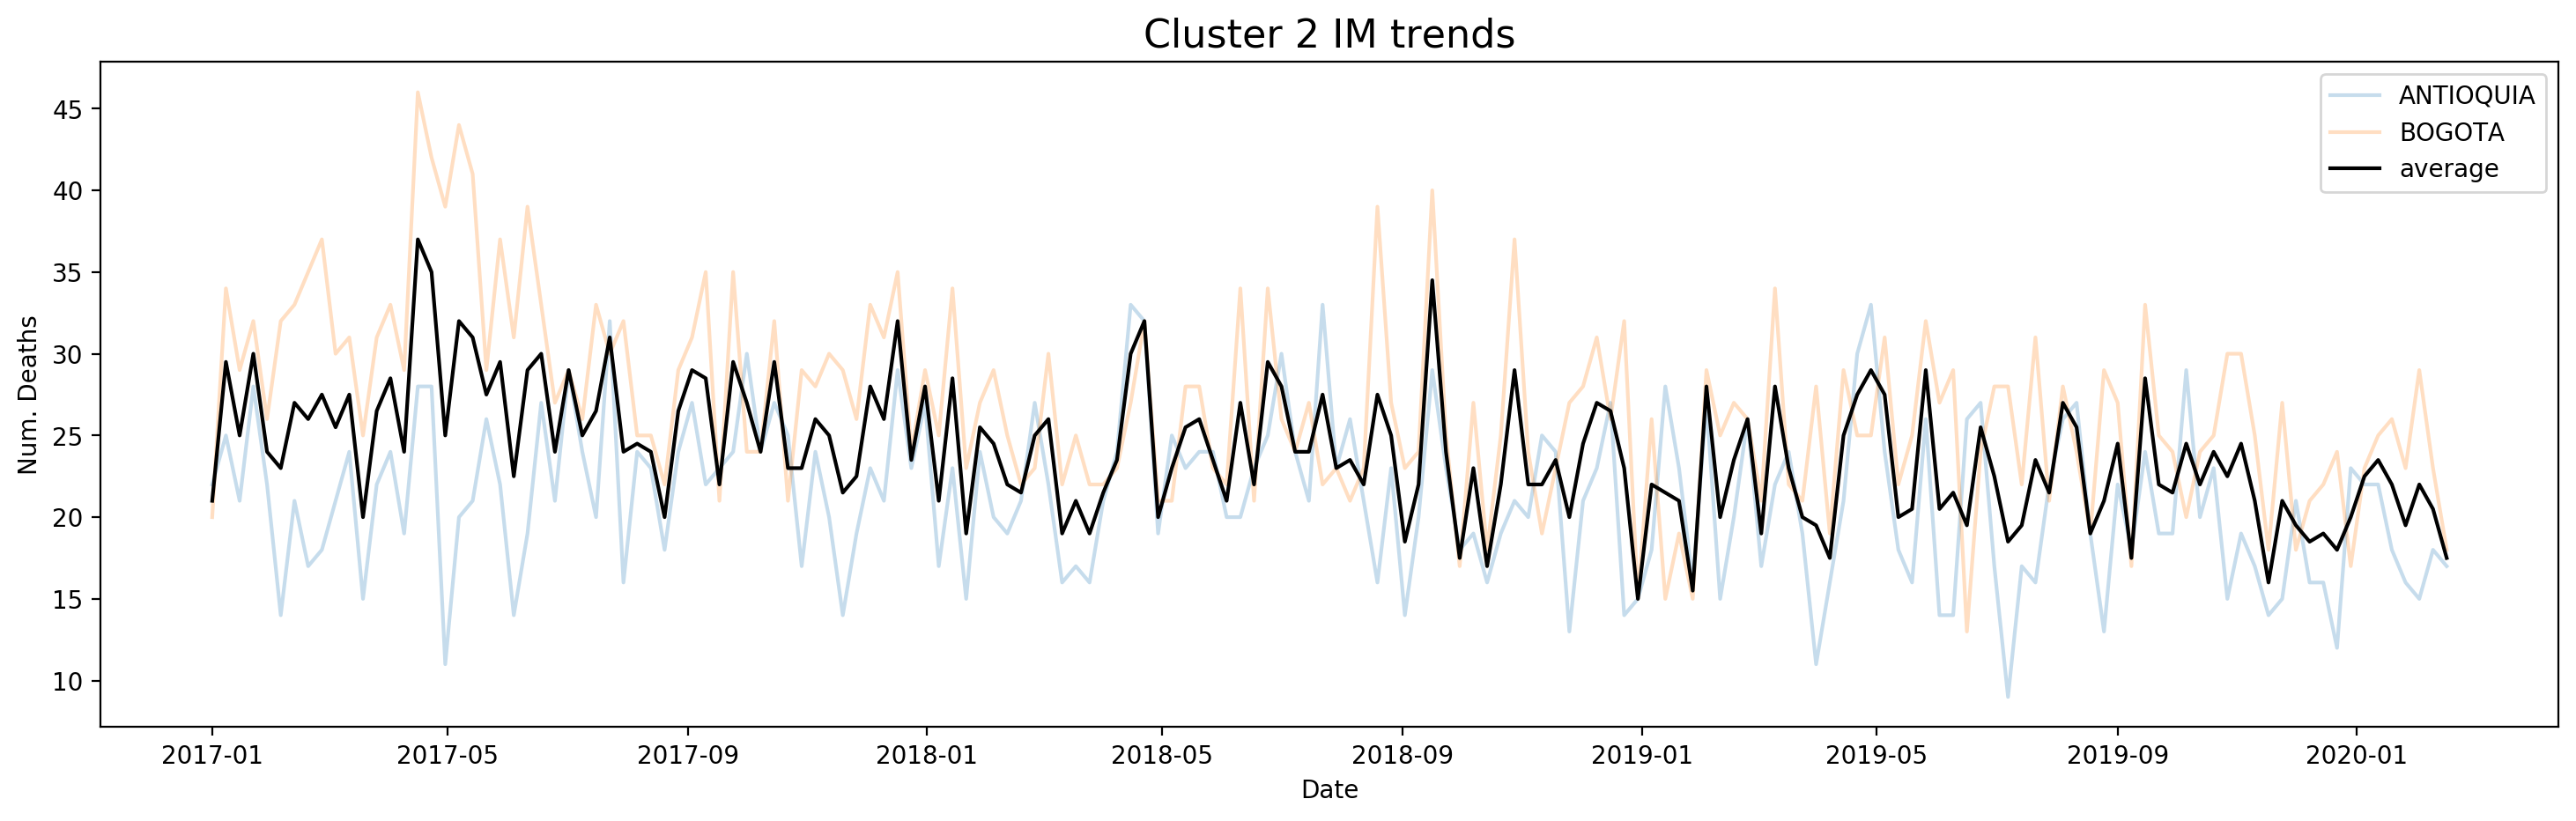

In [32]:
# Plot cluster 2
c_name = 2
plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

n time series: 7 , std dev: 14.223328093026753 max value: 22


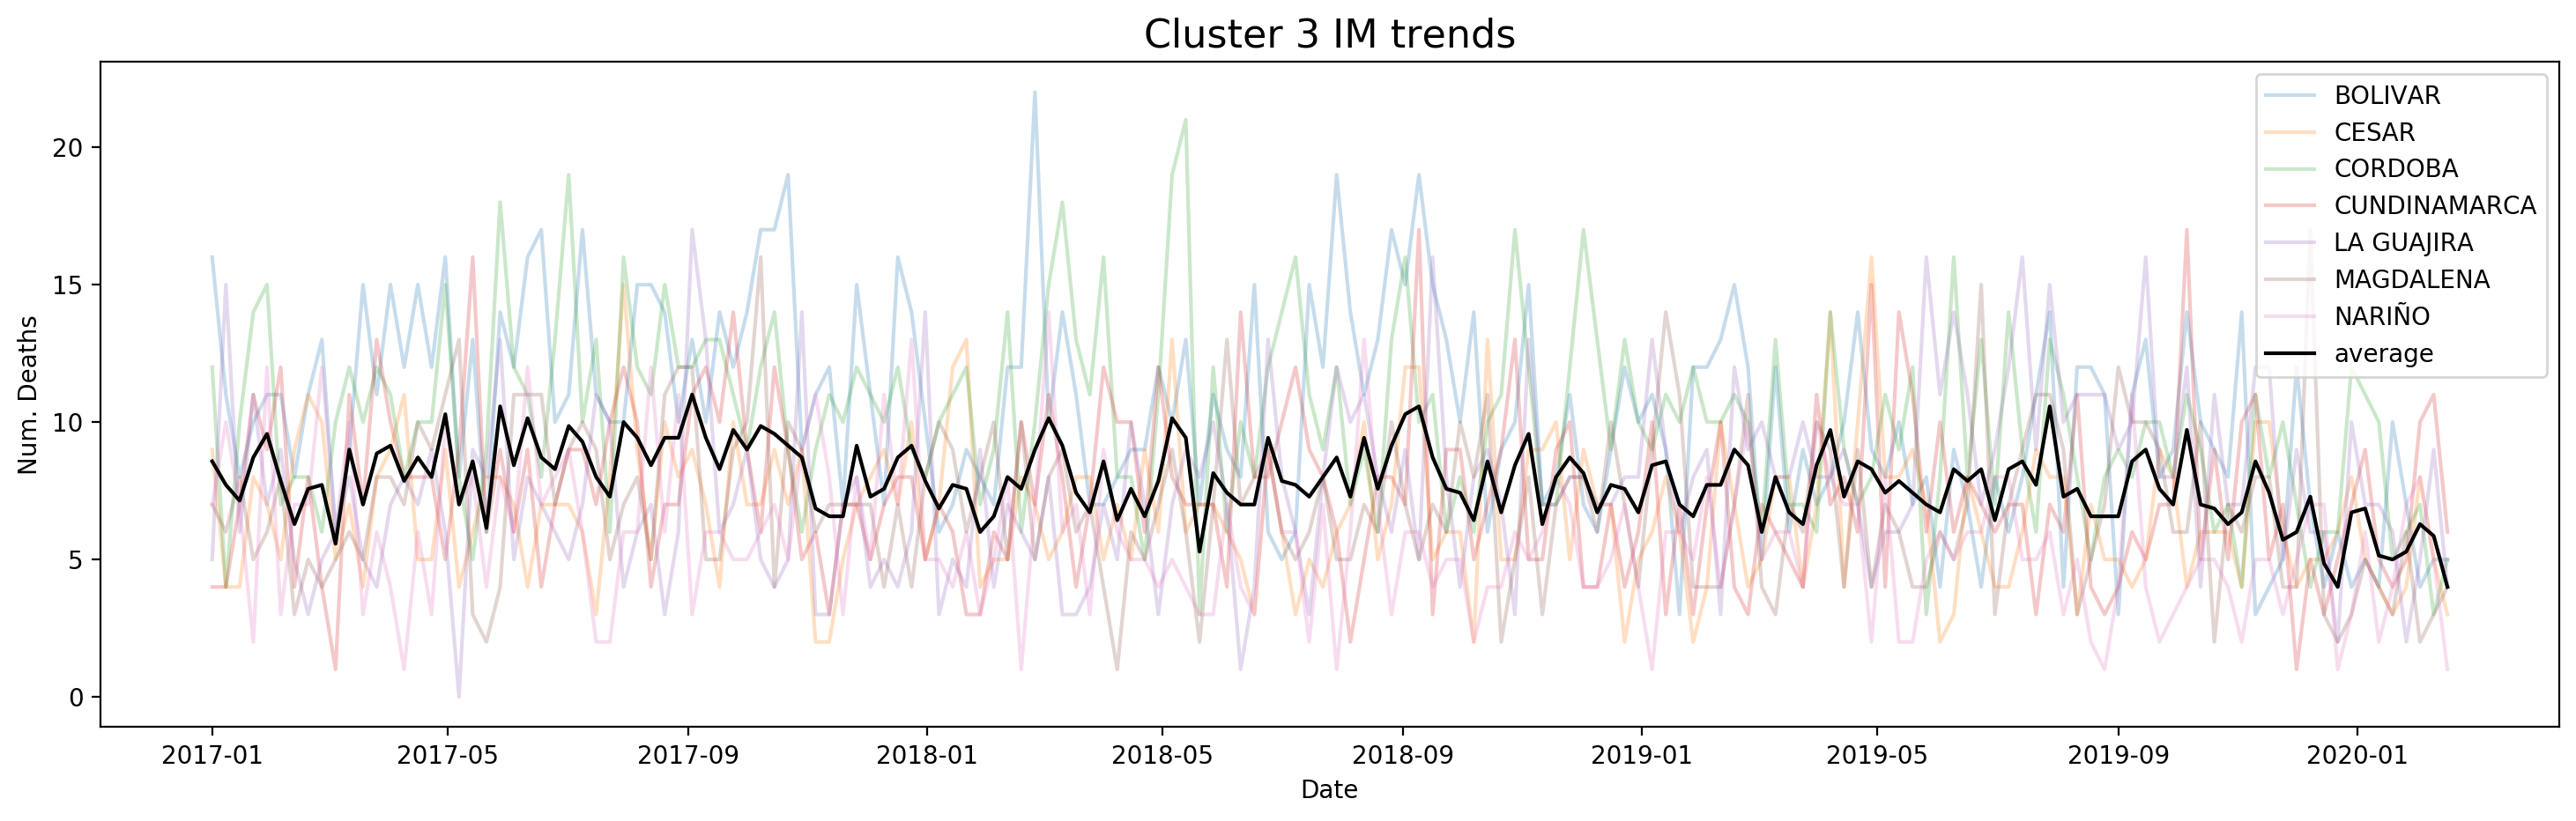

In [33]:
# Plot cluster 3
c_name = 3
plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

n time series: 2 , std dev: 7.877655389457121 max value: 31


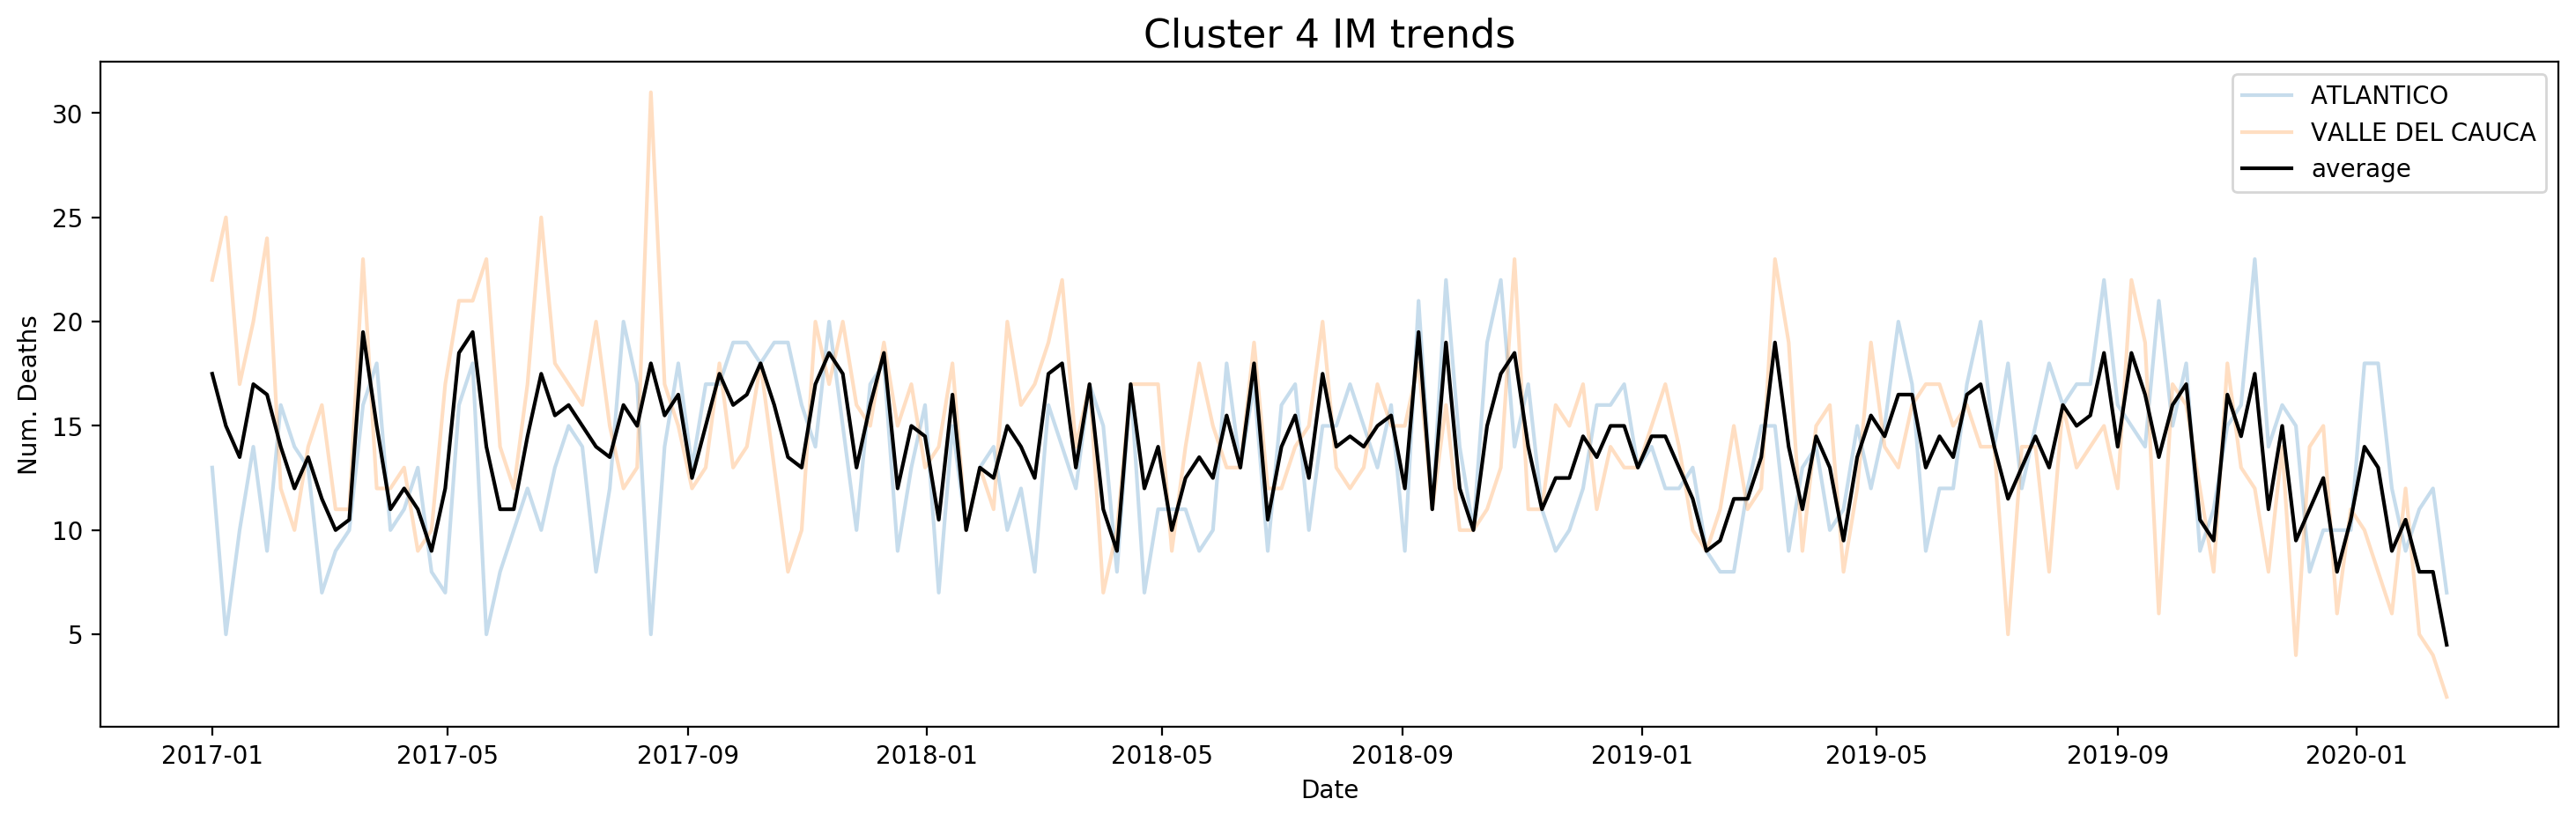

In [34]:
# Plot cluster 4
c_name = 4
plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

n time series: 9 , std dev: 16.83704247093466 max value: 13


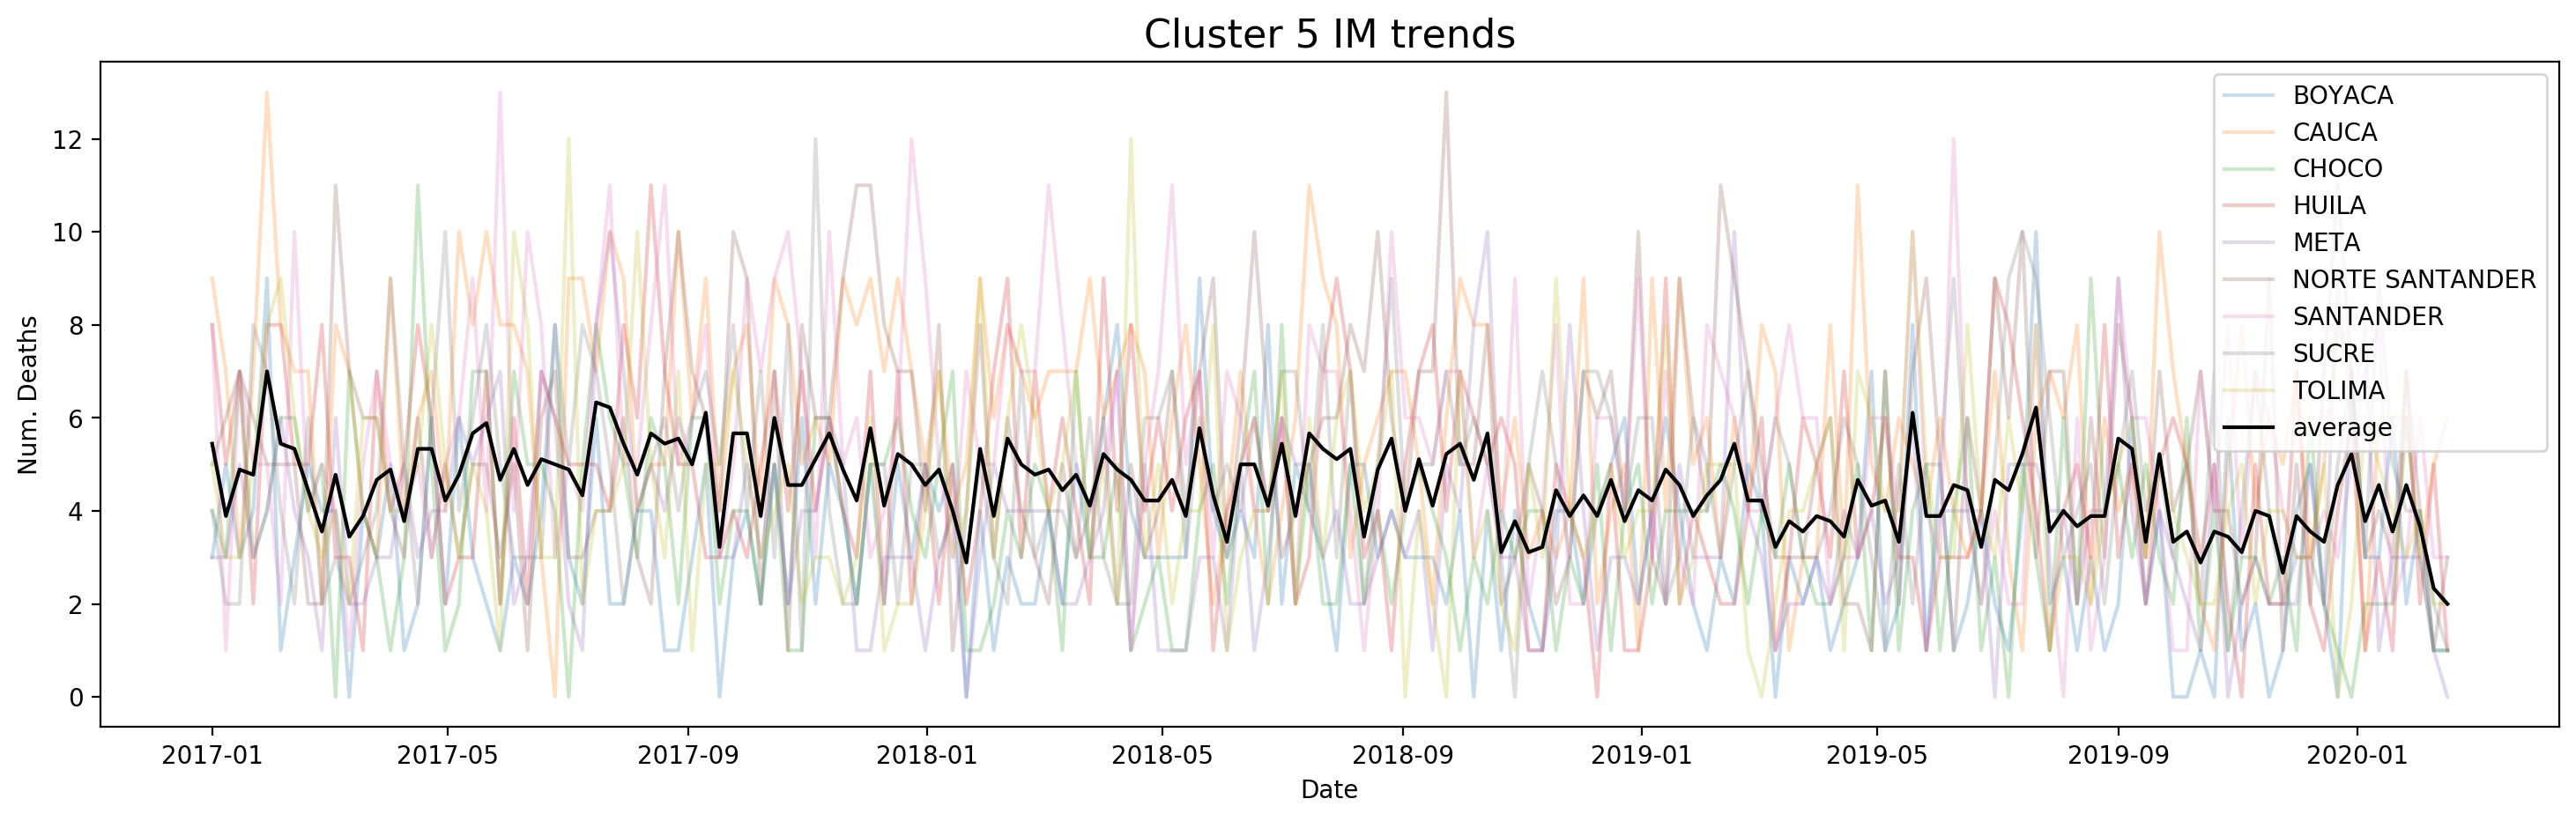

In [35]:
# Plot cluster 5
if n_cluster > 4:
    c_name = 5
    plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

In [36]:
# Plot cluster 6
if n_cluster > 5:
    c_name = 6
    plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

In [37]:
# Plot cluster 7
if n_cluster > 6:
    c_name = 7
    plot_cluster_curves(dpt_ts, dpt_cluster[c_name], c_name)

### 4.5. Show results

In [38]:
df_result

n_item    std_dev  n_item_2   w_std_dev
0    13.0  15.350276     169.0  199.553582
1     2.0   7.940085       4.0   15.880170
2     7.0  14.223328      49.0   99.563297
3     2.0   7.877655       4.0   15.755311
4     9.0  16.837042      81.0  151.533382

In [39]:
cluster_avg_item = math.sqrt(np.mean(df_result['n_item_2'].values))
avg_wn_std_dev = np.sum(df_result['w_std_dev'].values) / np.sum(df_result['n_item'].values)
print('Avg Items by Cluster: %0.4f' % cluster_avg_item)
print('Avg WN Std Dev: %0.4f' % avg_wn_std_dev)

Avg Items by Cluster: 7.8358
Avg WN Std Dev: 14.6147


---
End of analysis